In [167]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from IPython.display import display
import pandas
from astropy.coordinates import SkyCoord
import astropy.units as u

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 5.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

In [116]:
store = pandas.HDFStore("diffim_counts.h5",'r')

In [66]:
src = store['Sources']
src_coord = SkyCoord(ra=src['ra'], dec=src['dec'], unit=(u.deg, u.deg))
src['galactic_lat'] = src_coord.galactic.b.deg
src['galactic_lon'] = src_coord.galactic.l.deg

In [161]:
dia = store['diaSources']
del dia['ra']  # RA and Dec are broken in the dia source data for some reason
del dia['dec']

combined_table = pandas.merge(dia, src, how="left", on=["visitid", "ccdnum"],
                          suffixes=("_dia", "_src"))

grp = combined_table.groupby(['visitid'], as_index=False)
combined_visits = grp.agg({'counts_dia': np.sum,
                           'counts_src': np.sum,
                           'ra': np.mean,
                           'dec': np.mean,
                           'galactic_lat': np.mean,
                           'galactic_lon': np.mean,
                           'ccdnum': len}) # ccdnum becomes the number of ccds processed

templates = [197790, 197662, 197408, 197384, 197371]
combined_visits['is_template'] = [id in templates for id in combined_visits['visitid']]

In [162]:
combined_visits

,visitid,counts_src,galactic_lon,ccdnum,ra,counts_dia,galactic_lat,dec,is_template
0,197367,83582,297.602531,59,189.890971,19193,56.349672,-6.395522,False
1,197371,83557,297.603491,59,189.891583,7,56.350600,-6.394642,True
2,197375,84909,297.603371,59,189.891579,21344,56.351303,-6.393937,False
3,197379,83592,297.604578,59,189.892235,18118,56.351179,-6.394114,False
4,197384,96675,308.365939,59,196.784520,0,46.143028,-16.559995,True
5,197388,97143,308.366275,59,196.784738,25813,46.143265,-16.559738,False
6,197392,97169,308.367149,59,196.785340,27580,46.143543,-16.559409,False
7,197400,101503,312.342027,59,199.984636,17666,43.954165,-18.393293,False
8,197404,99841,312.341751,59,199.984364,20573,43.954560,-18.392935,False
9,197408,104206,312.342447,59,199.984858,11,43.954740,-18.392676,True


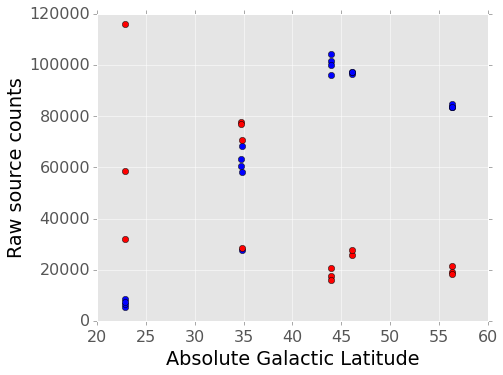

In [157]:
is_ok = combined_visits['is_template'] == False
plt.plot(np.abs(combined_visits['galactic_lat']), combined_visits['counts_src'], 'bo')
plt.plot(np.abs(combined_visits['galactic_lat'][is_ok]), combined_visits['counts_dia'][is_ok], 'ro')
plt.xlabel("Absolute Galactic Latitude")
plt.ylabel("Raw counts")

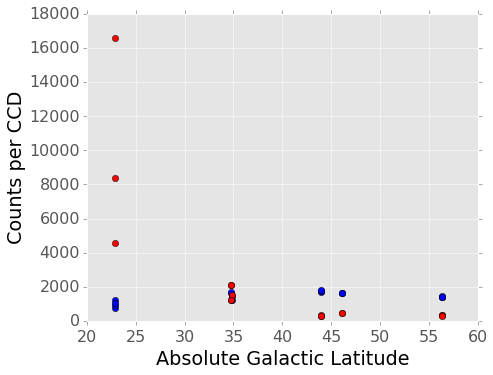

In [185]:
fig = plt.figure()
is_ok = combined_visits['is_template'] == False
plt.plot(np.abs(combined_visits['galactic_lat']),
         combined_visits['counts_src']/combined_visits['ccdnum'].astype(float), 'bo')
plt.plot(np.abs(combined_visits['galactic_lat'][is_ok]),
         (combined_visits['counts_dia']/combined_visits['ccdnum'].astype(float))[is_ok], 'ro')
plt.xlabel("Absolute Galactic Latitude")
plt.ylabel("Counts per CCD")
#plt.ylim(0,4000)

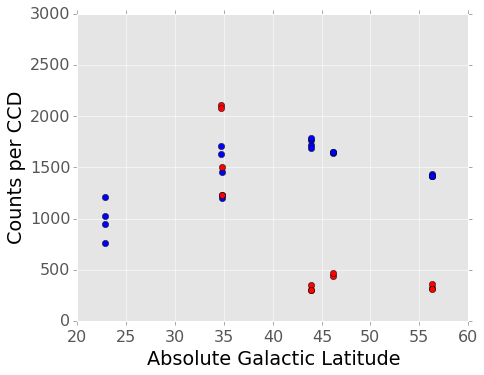

In [197]:
fig.axes[0].set_ylim(0,3000)
fig